In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import poisson
from scipy.stats import genpareto
from scipy.stats import poisson, genpareto
import re

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15

In [74]:
# Leemos bases de datos del fonden con montos pagados por año y por estado
fonden = pd.read_excel("data/FONDEN.xlsx")
fonden.dropna(axis=0, subset=["Estado"], inplace=True)
fonden["Estado"] = fonden.Estado.apply(lambda est: est.rstrip())

Análisis de la gravedad del siniestro de inundación por viviendas considerando año y estado. Creamos un heatmap mostrando los montos pagados por año.

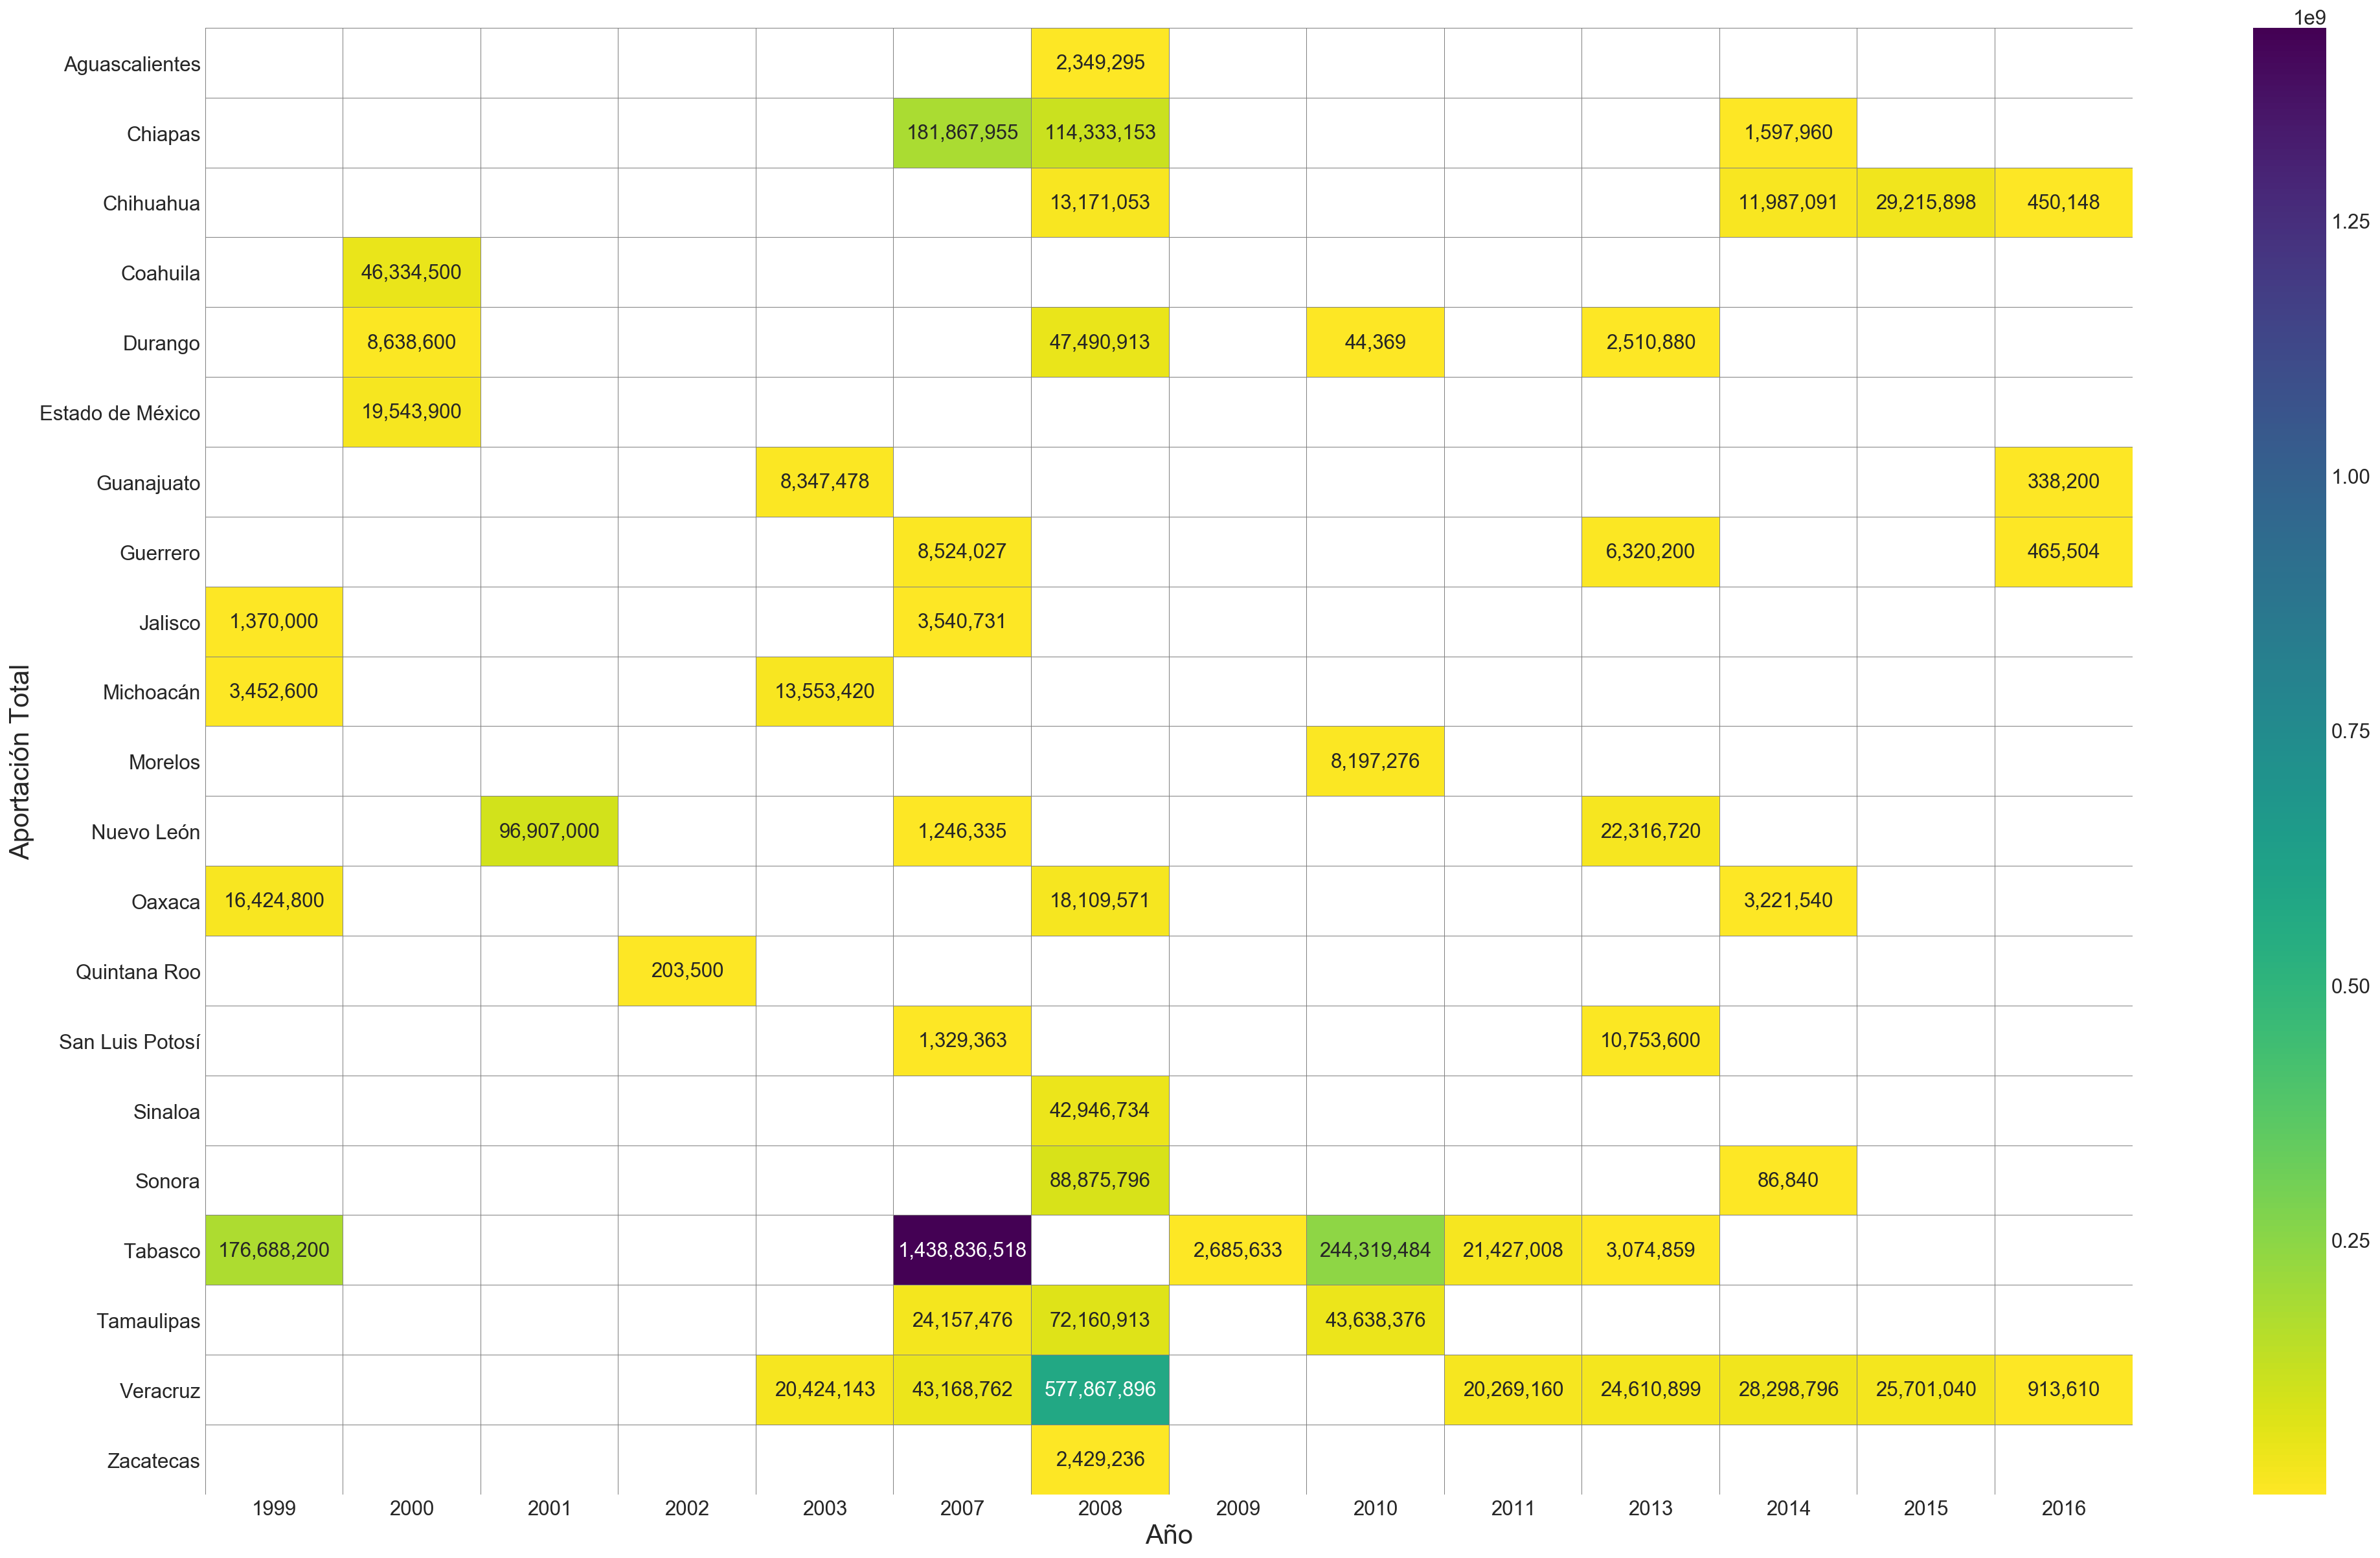

In [79]:
pt_fonden = fonden.pivot_table(values="Aportación TOTAL", columns="Año", index="Estado", aggfunc="sum")
plt.figure(figsize=(32,20), dpi=150)

ax = sns.heatmap(pt_fonden, cmap="viridis_r", annot=True,
                 linewidths=0.005, linecolor="gray", fmt=",.0f",
                 cbar=True, annot_kws={"size":15})
ax.set_xticklabels([int(float(y.get_text())) for y in ax.get_xticklabels()])
plt.ylabel("Aportación Total", size=20)
plt.xlabel("Año", size=20)
plt.show()

Graficamos la distribución de los siniestros, notámos que el *outlier* de la distribución lo lleva el estado de tabasco

In [90]:
max_ix = np.argmax(fonden["Aportación TOTAL"].values)
fonden[["Estado", "Aportación TOTAL"]].iloc[max_ix].values

array(['Tabasco', 709306453.0], dtype=object)

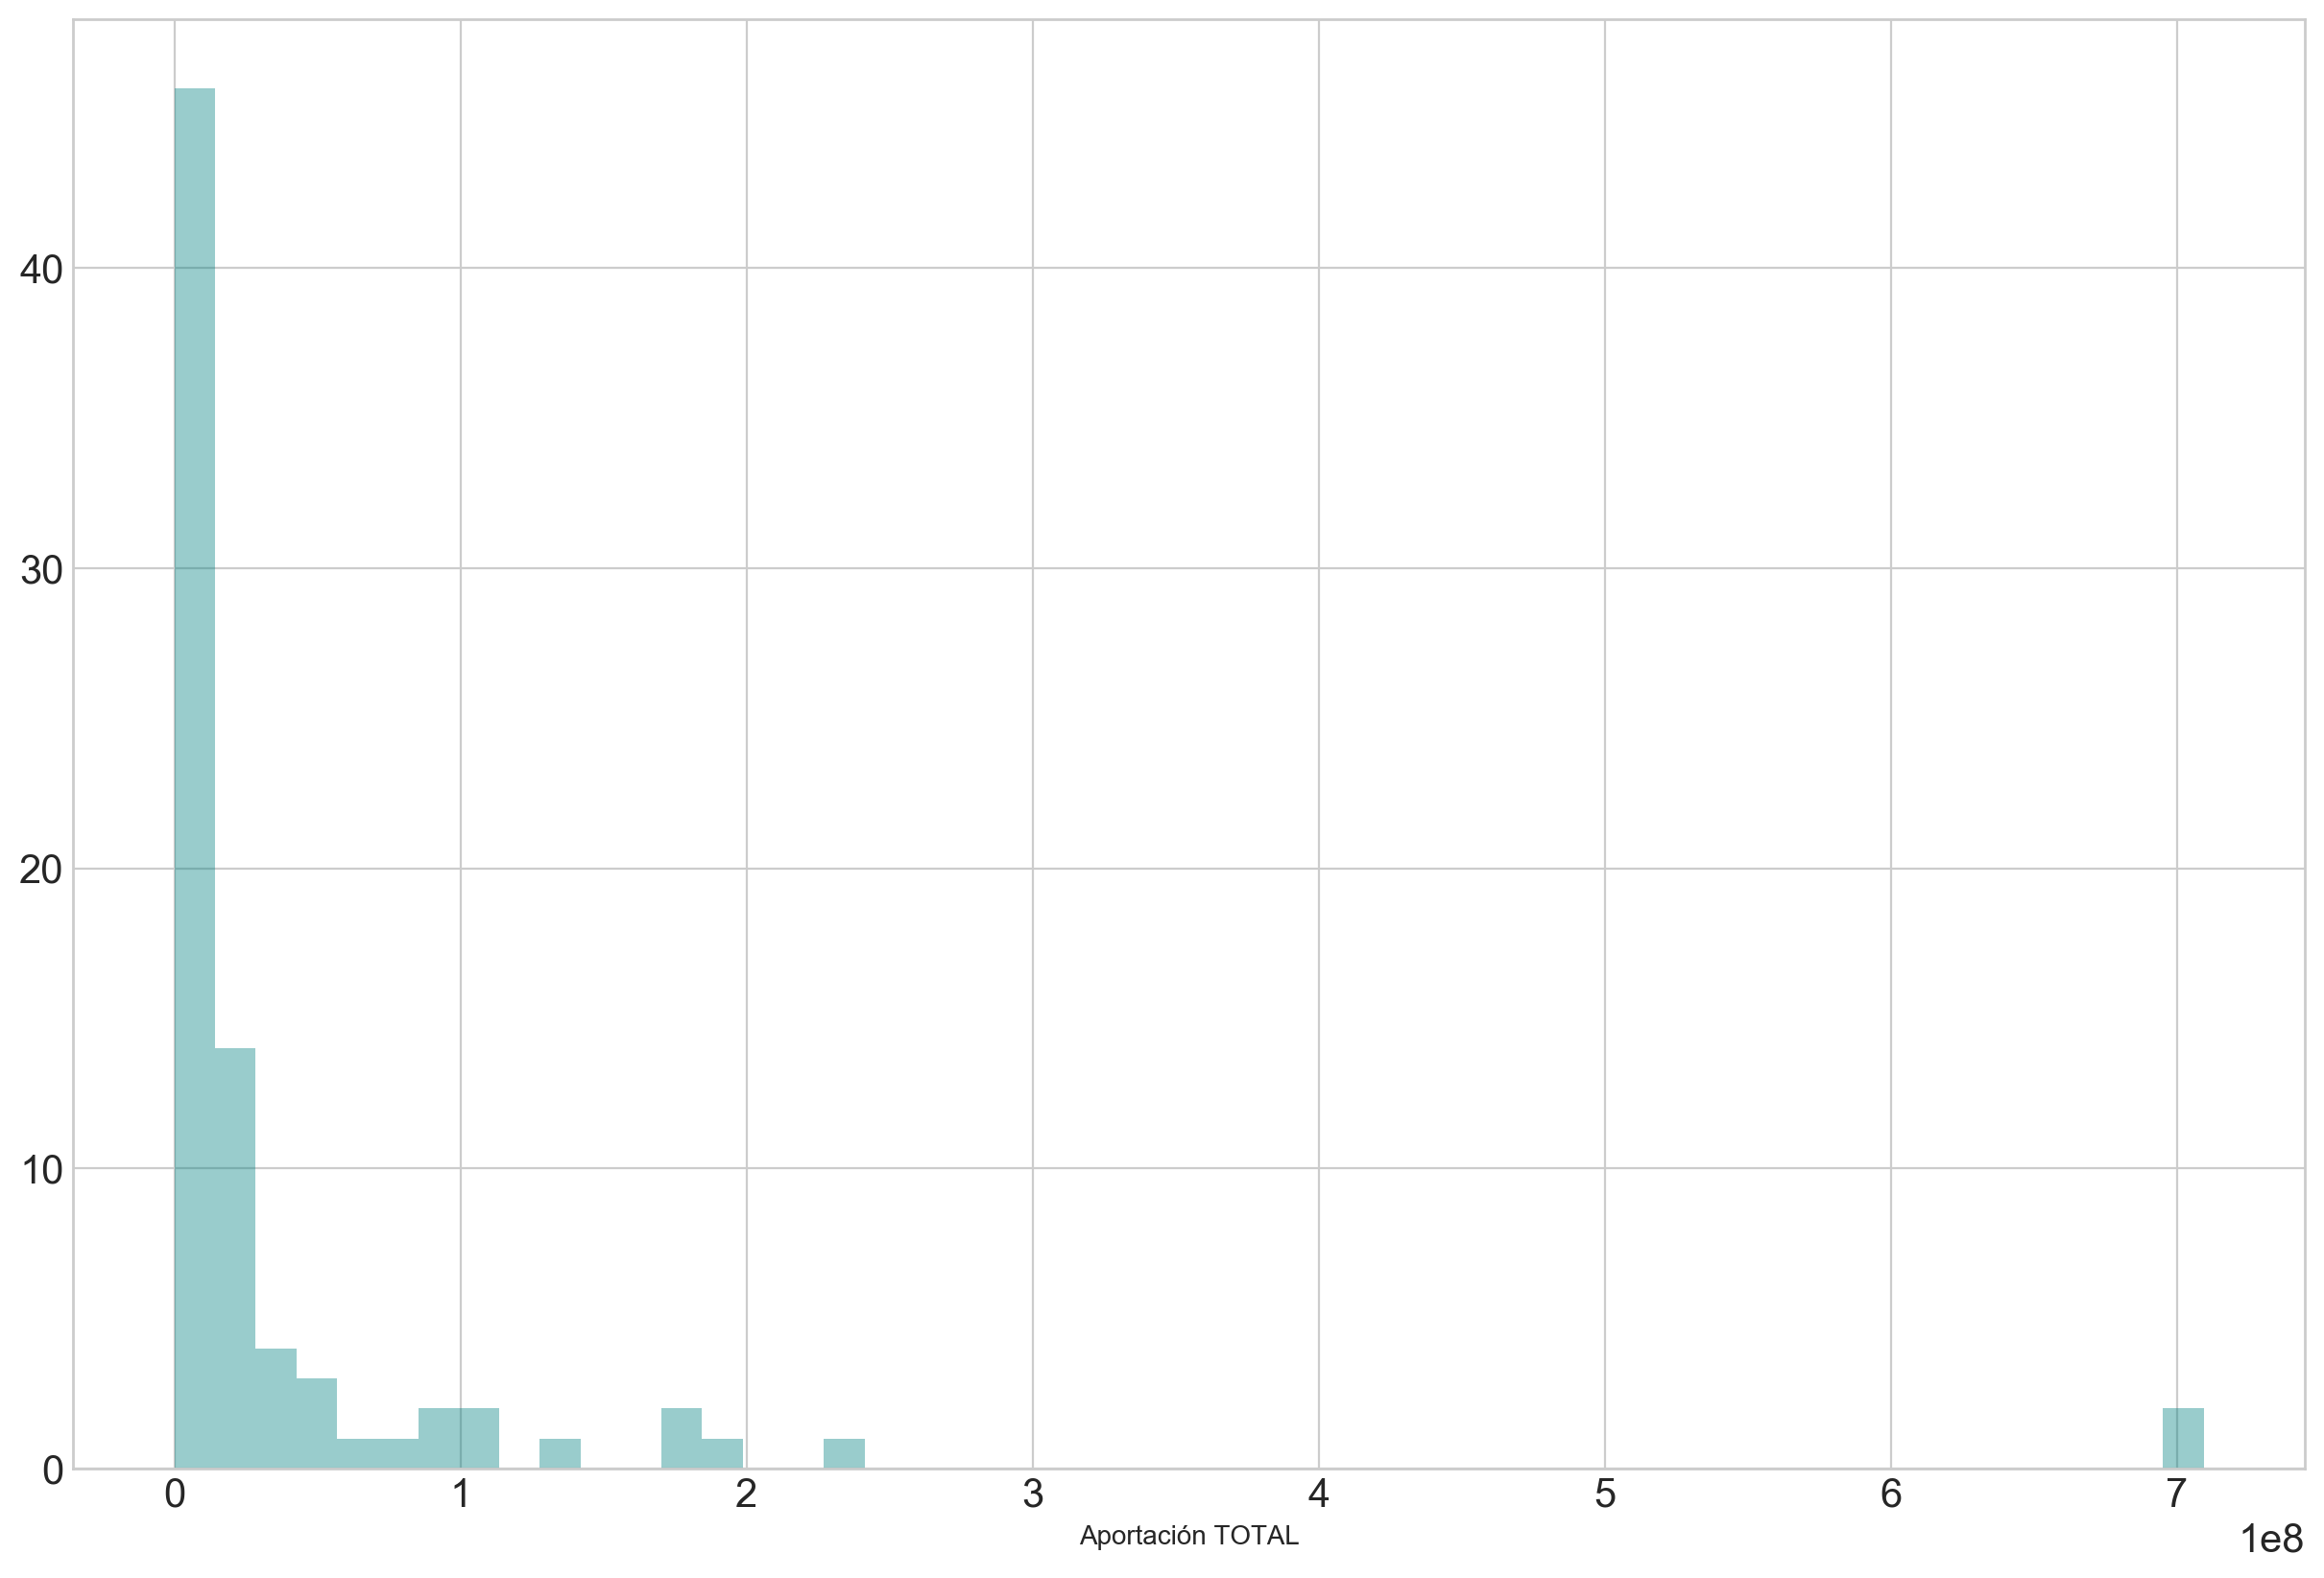

In [91]:
ax = sns.distplot(fonden["Aportación TOTAL"], color="teal", kde=False)
plt.show()

### Cálculo de $\lambda$ para el número de siniestros por año

Contamos, por año, cuantos incidentes se pagaron en total. Lo gráficamos

In [12]:
fonden_count_incidentes = fonden.groupby("Año").count()["Estado"]
fonden_count_incidentes

Año
1999.0     4
2000.0     3
2001.0     2
2002.0     1
2003.0     3
2007.0    12
2008.0    16
2009.0     1
2010.0     6
2011.0     3
2013.0    10
2014.0     9
2015.0     6
2016.0     4
Name: Estado, dtype: int64

In [13]:
years = fonden_count_incidentes.index
minyear = int(min(years))
maxyear = int(max(years))
for year in range(minyear, maxyear):
    if year not in years:
        fonden_count_incidentes[float(year)] = 0
fonden_count_incidentes.sort_index(inplace=True)

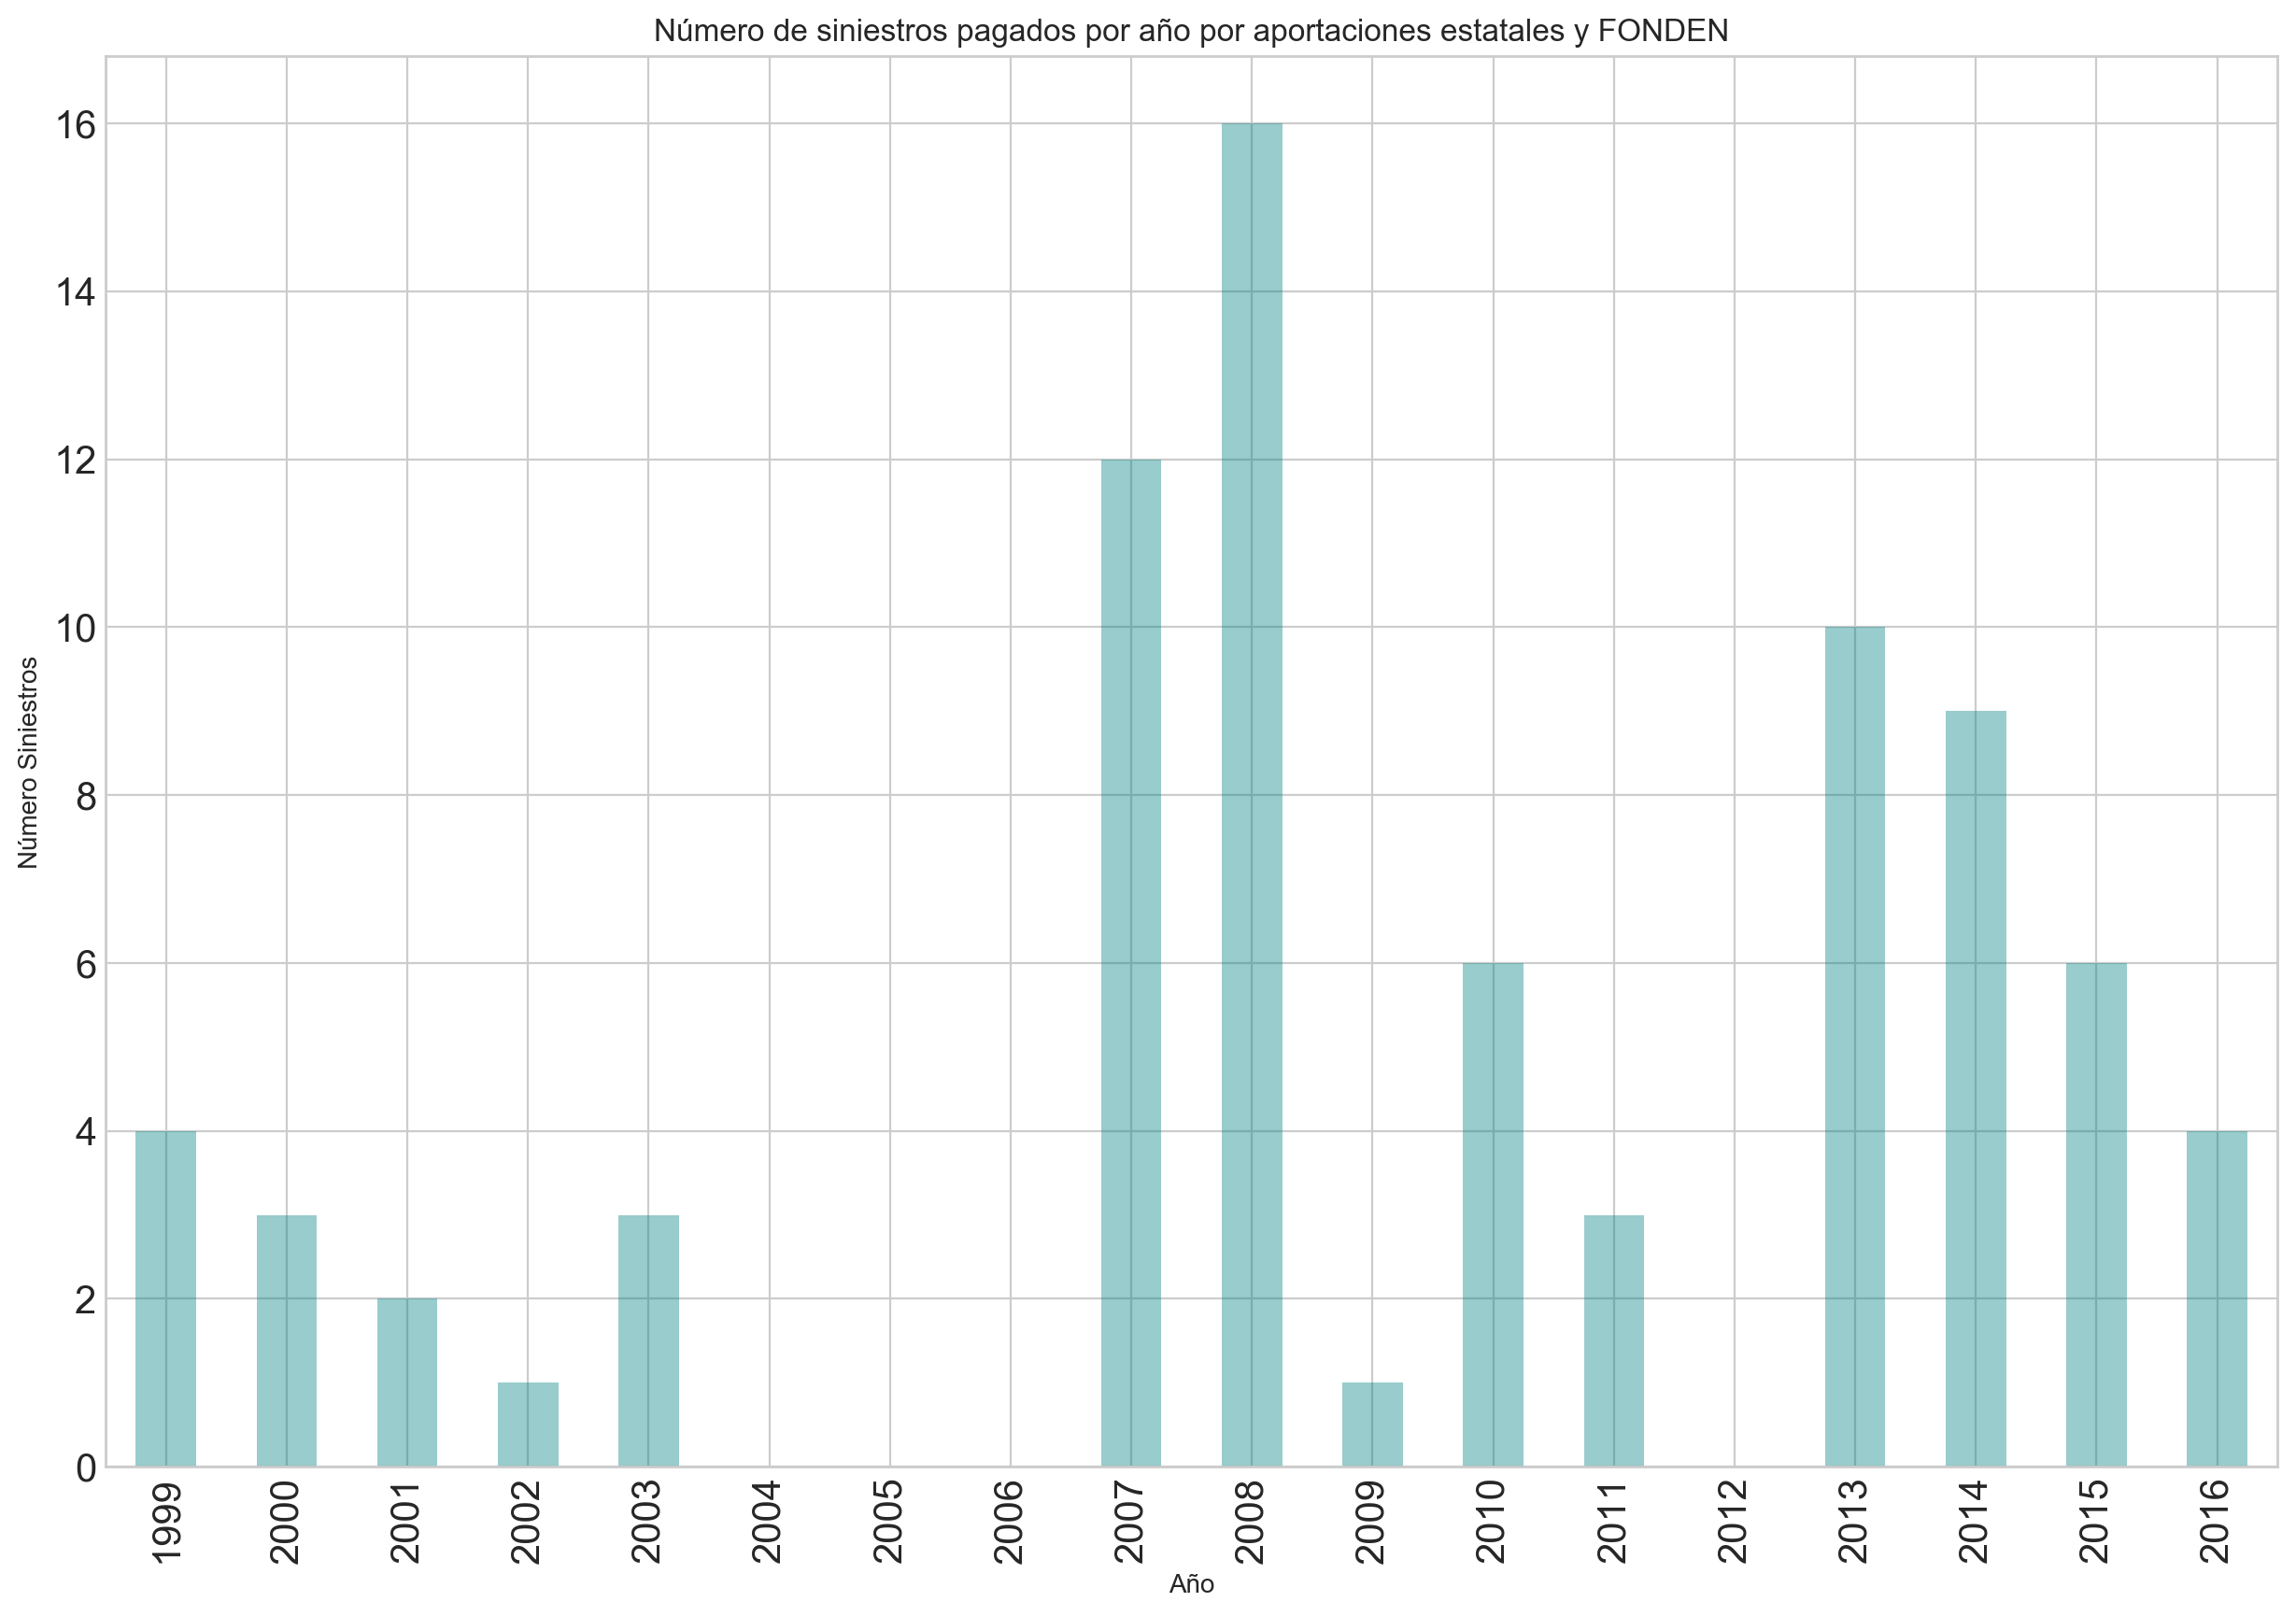

In [14]:
ax = fonden_count_incidentes.plot(kind="bar", color="teal", alpha=0.4)
ax.set_xticklabels([int(float(y.get_text())) for y in ax.get_xticklabels()])
ax.set_title("Número de siniestros pagados por año por aportaciones estatales y FONDEN")
ax.set_ylabel("Número Siniestros")
plt.show()

Con el número de incidentes pagados por año, calculamos el *número promedio de siniestros* por año. Este número, será el parámetro para la distribución de los datos
Esto es, pues asumimos que el número de incidentes por año se distribuye Poisson.

In [15]:
lmbda = fonden_count_incidentes.mean()
lmbda

4.444444444444445

### Cálculo de parametros de Pareto generalizada para la *gravedad* del siniestros

Estimaremos los parametros de la pareto generalizada considerando la función de densidad:

$$
    F_X(x; \mu, \sigma, \epsilon) = 1 - \left(1 + \frac{\epsilon(x - \mu)}{\sigma}\right)^{- 1 / \epsilon}
$$

Considerando que
$$
    \mathbb{E}[X] = \mu + \frac{\sigma}{1 - \epsilon},
$$
$$
    \mathbb{V}[X] = \frac{\sigma^2}{(1 - \epsilon)^2(1 - 2\epsilon)}
$$

Se puede demostrar
$$
    \mu = X^{(1)}, \text{el primer estadístico de orden};
$$
Y, por el método de momentos,
$$
    \hat \epsilon = \frac{1}{2}\left(1 - \frac{(\bar x - \mu)^2}{S^2}\right)
$$
$$
    \hat\sigma = (\bar x - \mu)(1 - \hat \epsilon)
$$

In [16]:
fondentot = fonden["Aportación TOTAL"]
mu = np.percentile(fondentot, 0.85)
mu = fondentot.min()
xbar = fondentot.mean()
s2 = fondentot.var()
epsilon_hat = (1 - (xbar - mu) ** 2 / s2) / 2
sigma_hat = (xbar - mu) * (1 - epsilon_hat)

In [70]:
mu, epsilon_hat, sigma_hat

(44369.0, 0.42608708479163071, 25848961.934938841)

1. Asumimos que nuestros datos (El monto de siniestro) es pareto;
2. Estimamos los parámetros de la distribución pareto; y
3. Gráficamos para una comparación visual.

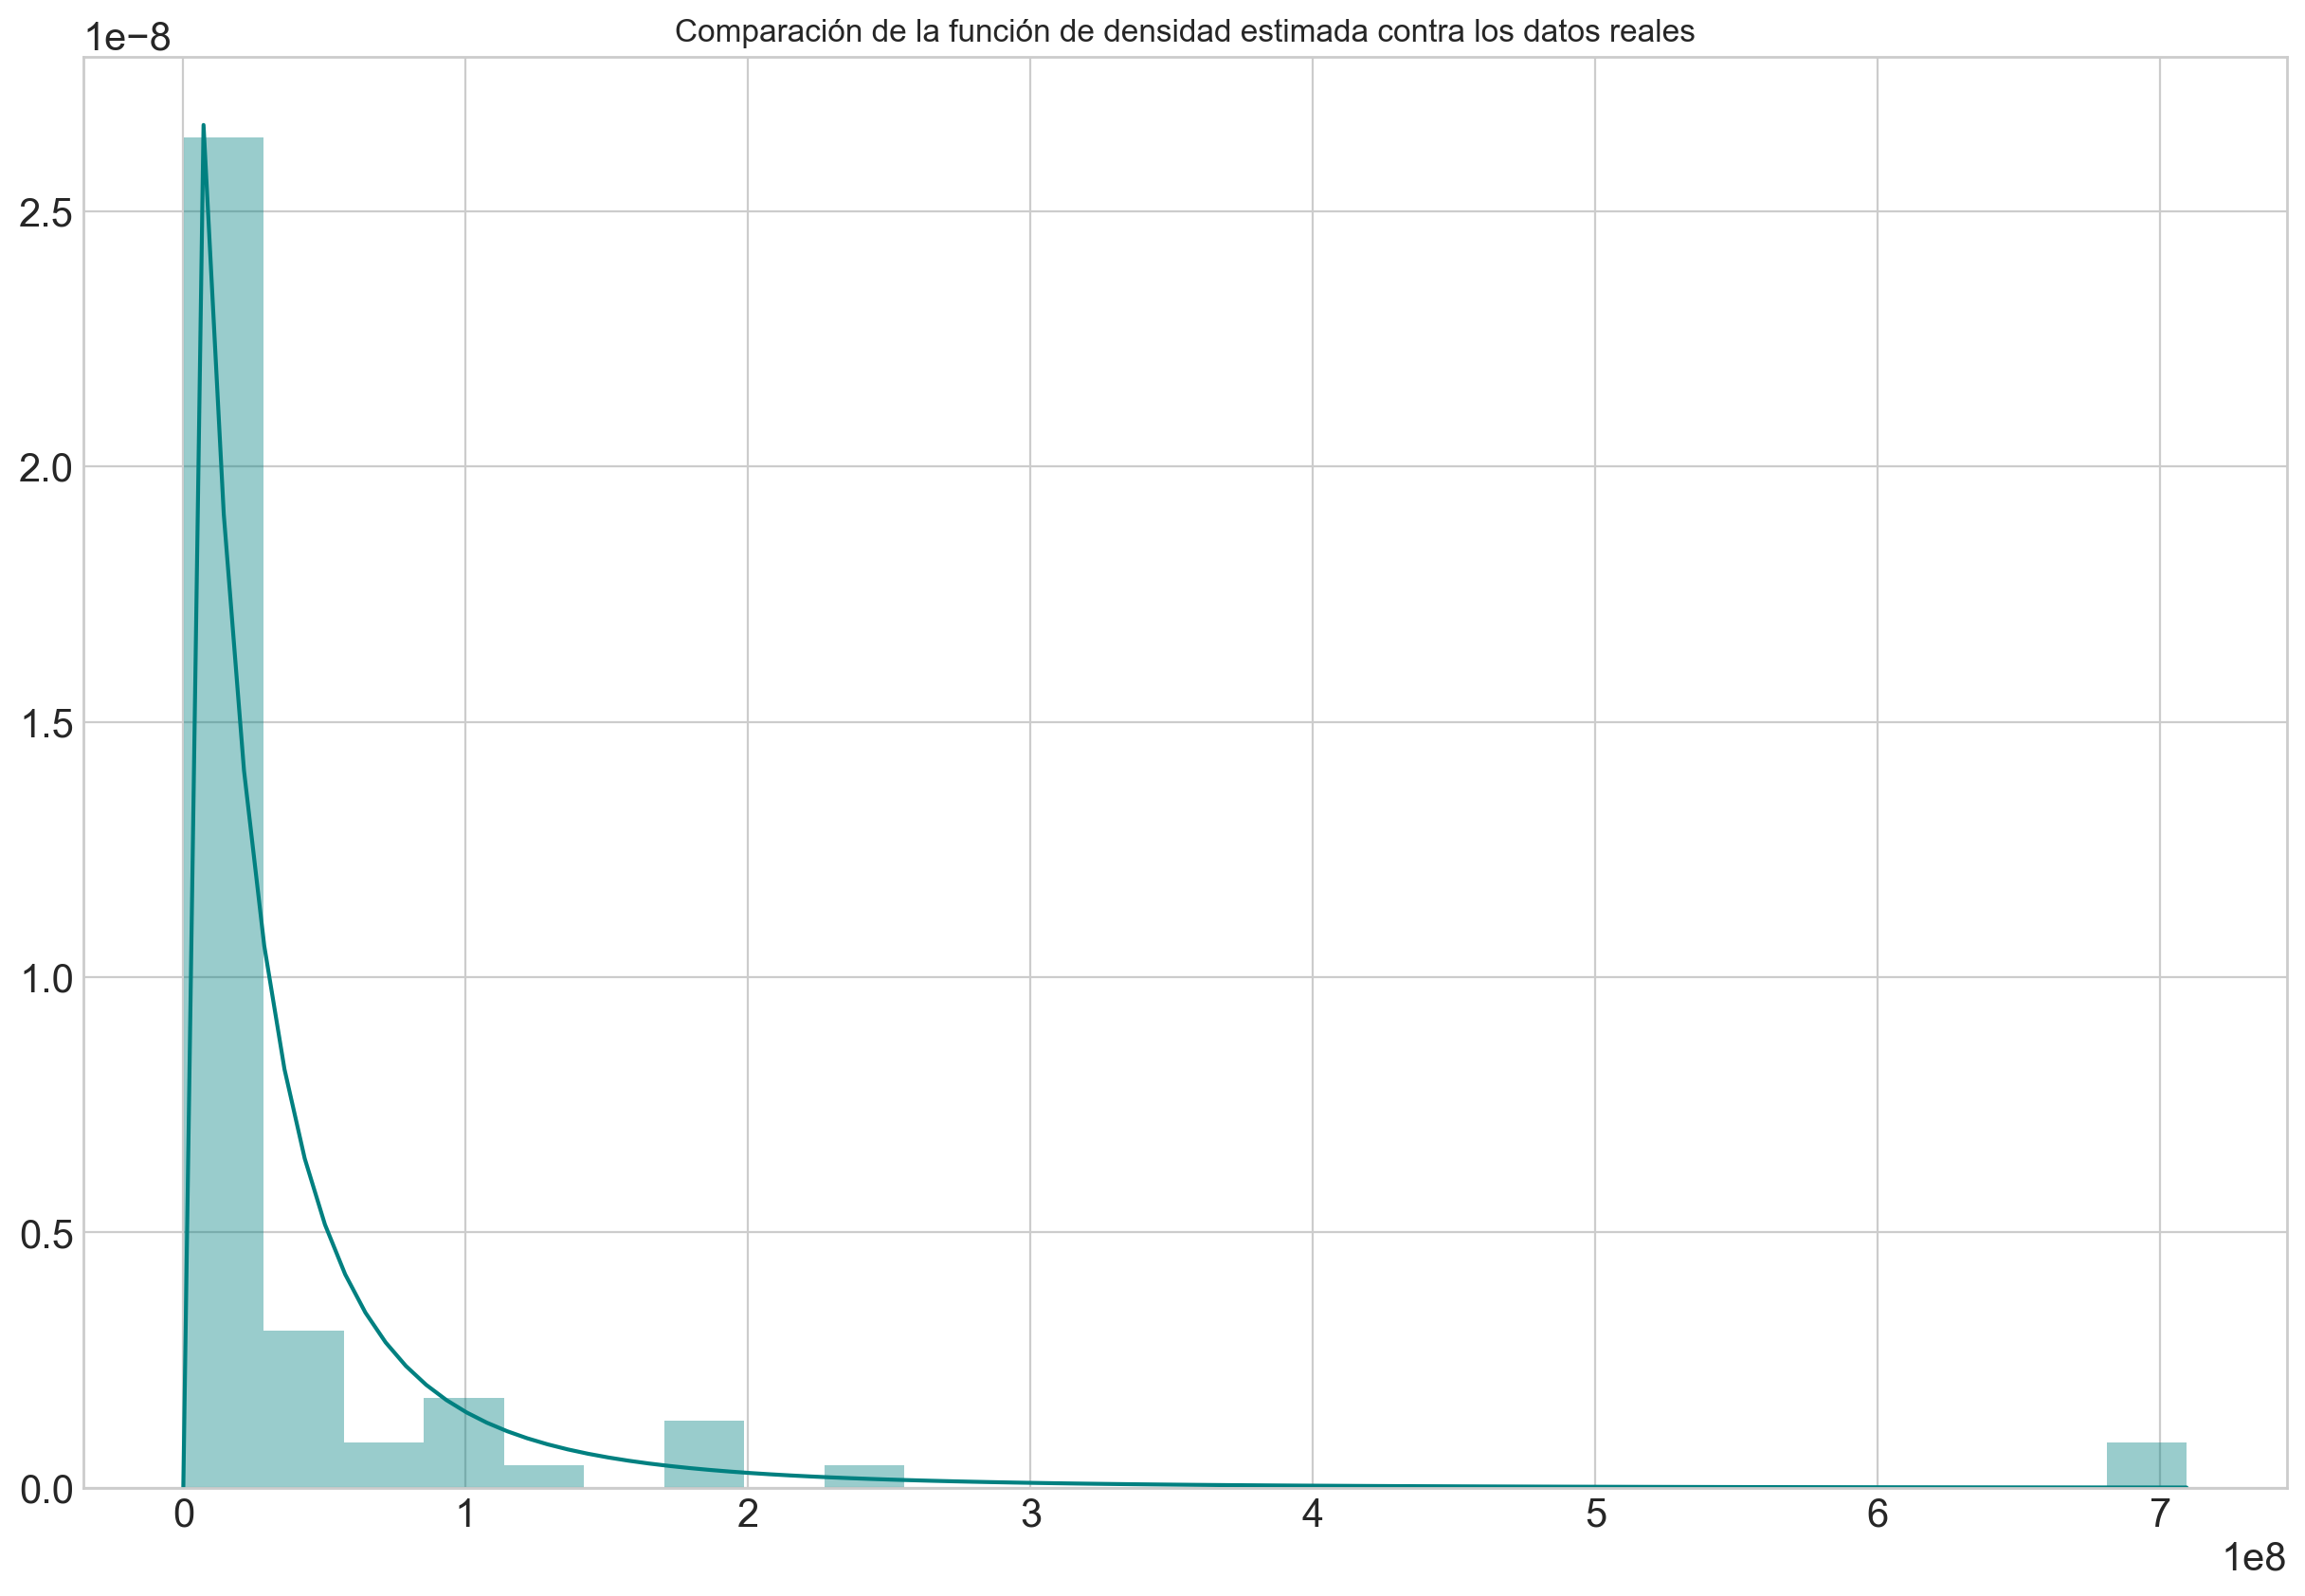

In [18]:
plt.figure(figsize=(15,10), dpi=200)
xrange = np.linspace(0, fondentot.max(), 100)
pdffonden = genpareto.pdf(xrange, epsilon_hat, mu, sigma_hat)
plt.plot(xrange, pdffonden, color="teal")
plt.hist(fondentot,  normed=True, bins=25, color="teal", alpha=0.4)
plt.title("Comparación de la función de densidad estimada contra los datos reales")
plt.show()

# Calculo de la prima de riesgo

Asumimos que el número de incidentes se comporta poisson. Por otro lado, la magintud de cada incidente se comporta como una pareto generailzada. 

Usamos los parametros estimados y simulamos 100,000 ocurrencias.

In [107]:
np.random.seed(1643)
# Simulación de numero de siniestros
incidents = poisson.rvs(lmbda, size=100_000)
# Simulación de la gravedad del siniestro
Sv = []
for n_inc in incidents:
    vals = genpareto.rvs(epsilon_hat, mu, sigma_hat, size=n_inc)
    Sv.append(sum(vals))

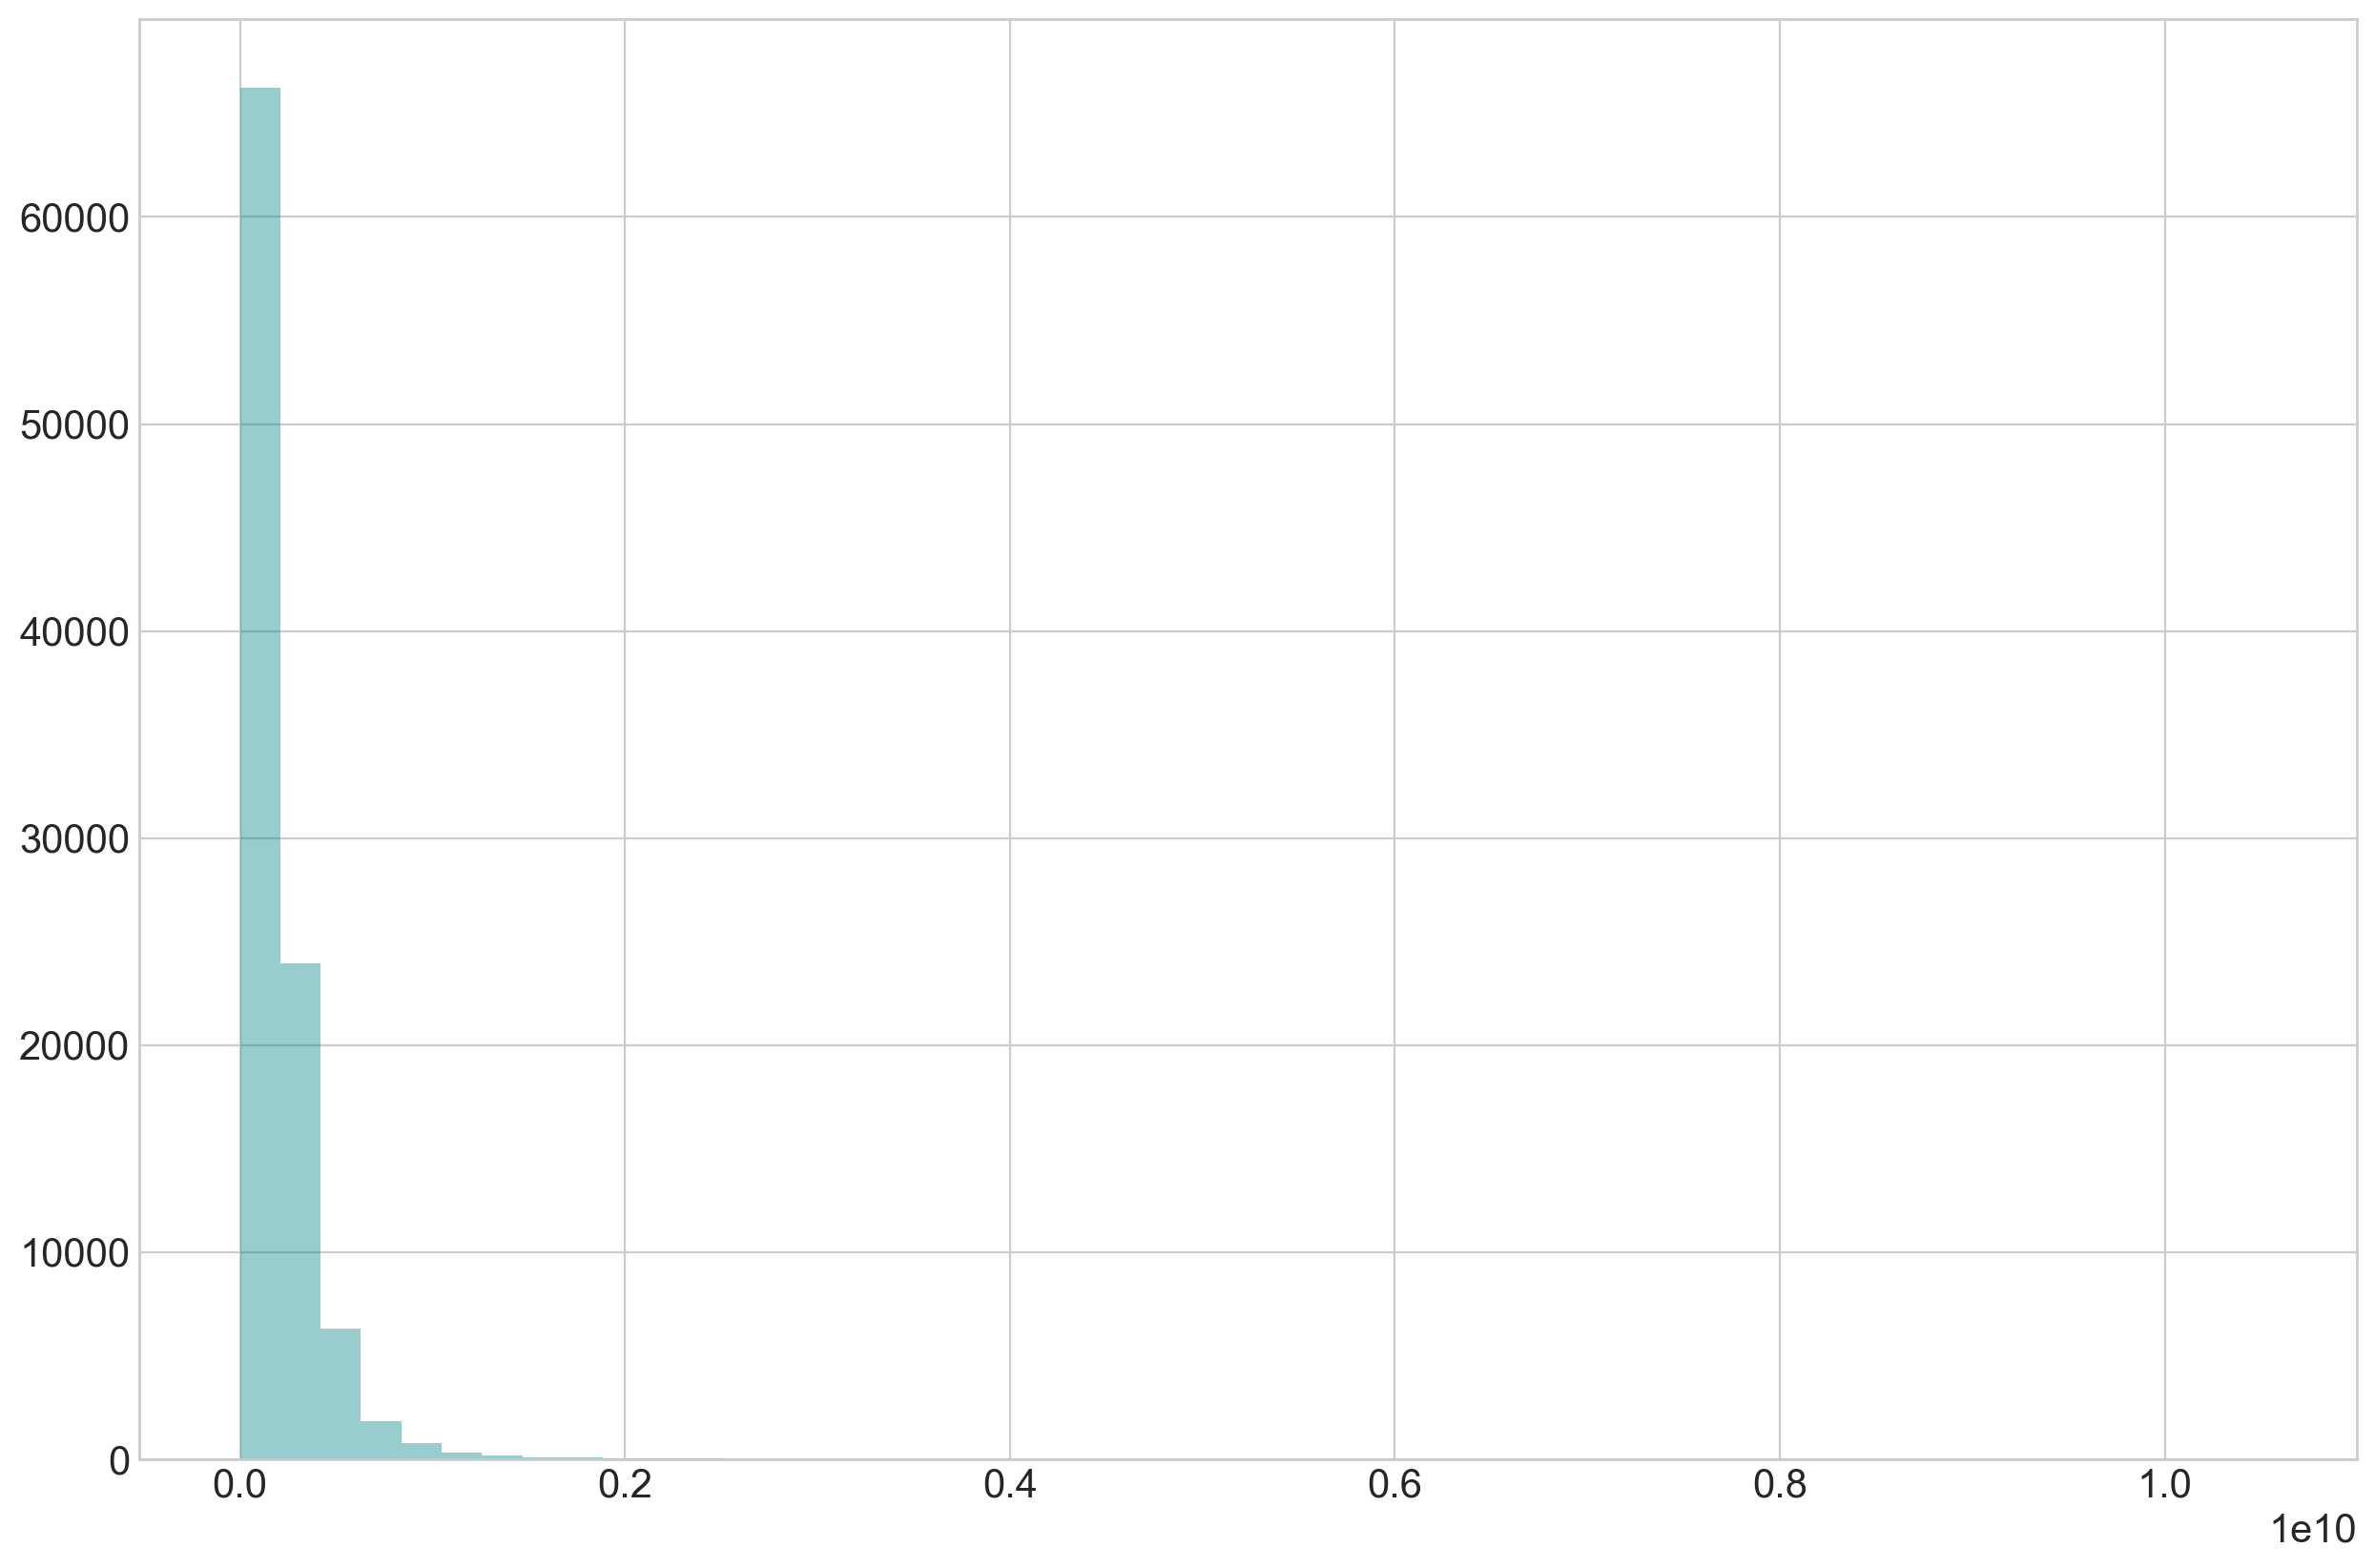

In [104]:
ax = sns.distplot(Sv, bins=50, color="teal", kde=False)
plt.show()

In [108]:
total_premium = np.mean(Sv)
print(f"Prima total a pagar: ${total_premium:,.2f}")

Prima total a pagar: $200,369,006.30


## Cálculo de prima por municipio con alto índice de pobreza:

### Limpieza de datos

In [440]:
# Definición de funciones para limpiar las bases de datos

def replace_acc(word):
    """
    Función para remover los acentos de una palabra en español.
    
    Parameters
    ----------
    word: str
        Palabra a eleminar acentos
    
    Returns
    -------
    str: palabra sin acentos
    """
    retword = str(word)
    acc_replace = [("a", "á"), ("e", "é"),
                   ("i", "í"), ("o", "ó"),
                   ("u", "ú")]
    for nonacc, acc in acc_replace:
        retword = retword.replace(acc, nonacc)
    return retword

def correct_article_word(word):
    """
    correge palalabras como: "zzz, el" o "zzz, la";
    las regresa de la forma: "el zzz" o "la zzz"
    
    Parameters
    ----------
    word: str
        Palabra a corregir (si es factible)
        
    Returns
    -------
    str: correción de la palabra
    """
    splits = re.split(", ([a-z]{1,3})", word)
    if len(splits) == 1:
        # No ocurrió ningun split
        return word 
    else:
        sust, art, _ = splits
        return f"{art} {sust}"

Leemos archivo de pobreza por estado y limpiamos los datos

In [377]:
pobreza = pd.read_csv("data/Indicadores_municipales_sabana_DA.csv", encoding="utf8")
pobreza.nom_mun = [replace_acc(mun).lower() for mun in pobreza.nom_mun.values]
pobreza.nom_ent = [replace_acc(ent) for ent in pobreza.nom_ent.values]

Leemos y limpiamos archivo de estados: nombre y siglas

In [389]:
estados = pd.read_table("./data/estados.txt", encoding="utf8")
# Limpiamos Números iniciales
estados.Estado = [est[3:].strip() for est in estados.Estado]
# Reemplaza puntos, capitalizado y sin acentos
estados.Abreviatura = [replace_acc(abb.replace(".", "")).upper()
                      for abb in estados.Abreviatura]

Leemos archivo de alto riesgo por municipio y estado

In [417]:
mun_high_risk = pd.read_csv("./data/high_risk.csv")
mun_high_risk.mun = [m.lower().strip() for m in mun_high_risk["mun"].values.tolist()]
mun_high_risk.mun = [correct_article_word(m) for m in mun_high_risk.mun]
mun_high_risk.state = [state.replace("-", "").strip() for state in mun_high_risk.state]

In [418]:
mun_high_risk.head()

,mun,state
0,mexicali,BCN
1,tecate,BCN
2,tijuana,BCN
3,ensenada,BCN
4,juarez,CHI


modificamos la tabla `mun_high_risk` para incluir el nombre de los estados (completo) con alto índice de exposición a inundaciones; tiramos las abreviaciones. Usamos la tabla `estados` para lograr esto.

In [419]:
mun_high_risk = mun_high_risk.merge(estados, left_on="state", right_on="Abreviatura")[["mun", "Estado"]]
mun_high_risk.head()

,mun,Estado
0,juarez,Chihuahua
1,buenaventura,Chihuahua
2,madera,Chihuahua
3,chihuahua,Chihuahua
4,cuauhtemoc,Chihuahua


Creamos el subconjunto de indice de pobreza (tabla `pobreza`) considerando solo los municipios con alto índice de riesgo `mun_high_risk`.

In [478]:
pobreza_high_risk = pobreza.merge(mun_high_risk,
                                  left_on=["nom_ent", "nom_mun"],
                                  right_on=["Estado", "mun"])
pobreza_high_risk.drop(["Estado", "mun"], inplace=True, axis=1)

Observamos la tabla subconjunto creada no incluye 6 municipios con alto nivel de riesgo

In [479]:
pobreza_high_risk.shape 

(141, 138)

In [480]:
mun_high_risk.shape

(147, 2)

In [474]:
print(f"{'*' * 20} Municpios no en la tabla {'*' * 20}")
for _, row in mun_high_risk.iterrows():
    if row.mun not in pobreza_high_risk.mun.values:
        print(f"{row.mun: >34} || {row.Estado}")

******************** Municpios no en la tabla ********************
                       jose azueta || Guerrero
                     matias romero || Oaxaca
                        pe¾amiller || Queretaro
                    alvaro obregon || Distrito Federal
zitlaltepec de trinidad sanchez s. || Tlaxcala
                            tuxpam || Veracruz de Ignacio de la Llave


In [475]:
# EXTRA MUNICIPALITIES IN ORDEN OF APPEAREANCE
# Another name for 'jose azueta';
# missing last name'avendaño';
# missing 'ñ';
# Accent 'á' was not caught (will be considered appart);
# Abbreviated 'santos';
# tuxpan not found (will be considered appart)

extra_mun = ["zihuatanejo de azueta", "peñamiller", "matias romero avendaño",
             "ziltlaltepec de trinidad sanchez santos"]

In [494]:
missin_data = (pobreza.query(f"nom_mun in {extra_mun}")
 .append(pobreza.query(("nom_mun == 'álvaro obregon'and nom_ent == 'Distrito Federal'")))
 .append(pobreza.query(("nom_mun == 'tuxpan'and nom_ent == 'Veracruz de Ignacio de la Llave'")))
)

pobreza_high_risk = pobreza_high_risk.append(missin_data)
pobreza_high_risk.shape 

(147, 138)

In [501]:
# Obteniendo columnas necesarias para calcular número total de habitantes
# clasificados en condiciones de pobreza que
# viven en zonas peligrosas de inundaciones
pobreza_high_risk = pobreza_high_risk[["pobtot_ajustada", "pobreza"]]

## Cálculo final de la prima

De Acuerdo al [INEGI](http://www.inegi.org.mx/saladeprensa/boletines/2016/especiales/especiales2016_06_05.pdf), la familia promedio, hacia el 2005, lo integraban 3.8 miembros de la familia. Considerando este hecho, calculamos la prima si cada persona pagara una prima y, por otro lado, la prima por familia considerando el dato de INEGI.

In [518]:
total_asegurados_personas = pobreza_high_risk.values.prod(axis=1).sum()
total_asegurados_familias = (pobreza_high_risk.values.prod(axis=1) / 3.8).sum()
print(f"Número total de personas que serían cubiertas por el seguro: {total_asegurados_personas:,.0f}")
print(f"Número total de familias que serían cubiertas por el seguro: {total_asegurados_familias:,.0f}")

Número total de personas que serían cubiertas por el seguro: 10,303,321
Número total de familias que serían cubiertas por el seguro: 2,711,400


In [533]:
prima_personas = total_premium / total_asegurados_personas
prima_familias = total_premium / total_asegurados_familias
print(f"El costo de la prima por cada asegurado sería de {prima_personas:,.2f} MXN")
print(f"El costo de la prima por cada familia sería de {prima_familias:>7,.2f} MXN")

El costo de la prima por cada asegurado sería de 19.45 MXN
El costo de la prima por cada familia sería de   73.90 MXN
